# Heston Calibration on Market Data (Forward-Based)

In this notebook we:
1. Load AAPL option chain data with our custom `data_loader` functions.  
2. Use put–call parity regression to infer **forwards** and **discount factors** per expiry (so no need to guess dividends).  
3. Calibrate the Heston model by minimizing weighted squared price errors.  
4. Diagnose convergence and visualize market vs model smiles.  
5. Report mean/median absolute pricing errors.


## Import pricers

We use our COS-method Heston pricer and BS pricer from the `options_pricing` package.


In [14]:
# Imports
import os, sys, numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["font.family"] = "Times New Roman" # Set font to Times New Roman
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if repo_root not in sys.path:
    sys.path.append(repo_root)

from src.heston import heston_price
from src.black_scholes import black_scholes_price
from data.data_loader import fetch_stock_data, fetch_current_chain,compute_annualized_volatility,get_latest_price


## Fetch data

- Underlying = AAPL  
- Spot price from stock history  
- Current option chain from Yahoo Finance  
- Construct working DataFrame


In [2]:
TICKER = "AAPL"

stock_df = fetch_stock_data(TICKER, start="2024-01-01")
S0 = get_latest_price(stock_df)
iv_proxy_hist = compute_annualized_volatility(stock_df)

raw_chain = fetch_current_chain(TICKER)
raw_chain["type"] = raw_chain["type"].str.lower()

now = pd.Timestamp.utcnow().tz_localize(None)
df = raw_chain.copy()
df["underlying"] = S0
df["T"] = (df["expiration"] - now).dt.days / 365.25
df["K"] = df["strike"]
df["side"] = df["type"]

# Ensure bid/ask columns exist
if "bid" not in df.columns: df["bid"] = np.nan
if "ask" not in df.columns: df["ask"] = np.nan

# Basic cleaning
df = df[(df["T"] > 2/365) & (df["K"] > 0) & (df["mid"] > 0)].copy()

# Weights: inverse spread if available
spr = (df["ask"] - df["bid"]).replace([np.inf,-np.inf], np.nan)
df["w"] = 1.0
df.loc[spr.notna() & (spr > 0), "w"] = 1.0 / spr.clip(lower=0.05)

df.head()


[*********************100%***********************]  1 of 1 completed


,expiration,strike,type,mid,underlying,T,K,side,bid,ask,w
164,2025-09-26,110.0,call,128.175,238.149994,0.024641,110.0,call,NaN,NaN,1.0
165,2025-09-26,120.0,call,118.325,238.149994,0.024641,120.0,call,NaN,NaN,1.0
166,2025-09-26,125.0,call,113.350,238.149994,0.024641,125.0,call,NaN,NaN,1.0
167,2025-09-26,130.0,call,108.175,238.149994,0.024641,130.0,call,NaN,NaN,1.0
168,2025-09-26,135.0,call,103.400,238.149994,0.024641,135.0,call,NaN,NaN,1.0


## Step 1: Infer forwards and discount factors

We use put–call parity regression per expiry:
$$\
C(K,T) - P(K,T) = DF_T \,(F_{0,T} - K).
$$


In [3]:
pairs = (df
         .pivot_table(index=["expiration","T","K"],
                      columns="side", values="mid", aggfunc="mean")
         .reset_index())

pairs = pairs.dropna(subset=["call","put"]).copy()
pairs["y"] = pairs["call"] - pairs["put"]

per_exp = []
for (exp,), grp in pairs.groupby(["expiration"]):
    K = grp["K"].values
    y = grp["y"].values
    if len(K) < 3:
        continue
    X = np.vstack([np.ones_like(K), K]).T
    beta, *_ = np.linalg.lstsq(X, y, rcond=None)
    a, b = beta
    DF = max(1e-9, -b)
    F  = a / DF
    T  = float(np.nanmean(grp["T"]))
    per_exp.append({"expiration": pd.to_datetime(exp), "T": T, "DF": DF, "F0T": F})

forw = pd.DataFrame(per_exp)
forw["r_eff"] = np.where(forw["T"] > 0, -np.log(forw["DF"]) / forw["T"], 0.0)
forw.sort_values("T").head()


,expiration,T,DF,F0T,r_eff
0,2025-09-26,0.024641,1.004071,238.211399,-0.164891
1,2025-10-03,0.043806,1.001956,238.502307,-0.044600
2,2025-10-10,0.062971,1.003165,238.729485,-0.050189
3,2025-10-17,0.082136,1.006747,237.484426,-0.081866
4,2025-10-24,0.101300,1.004690,238.994707,-0.046192


## Step 2: Join forwards back to quotes
We now have `S_adj = DF * F0T` and `r_eff`. No dividend guess required.


In [4]:
df_f = (df
        .merge(forw[["expiration","DF","F0T","r_eff","T"]], on=["expiration","T"], how="inner")
        .copy())

df_f["S_adj"] = df_f["DF"] * df_f["F0T"]

df_f = df_f[(df_f["T"] > 7/365) & (df_f["K"] > 0) & (df_f["mid"] > 0)].copy()
df_f.head()


,expiration,strike,type,mid,underlying,T,K,side,bid,ask,w,DF,F0T,r_eff,S_adj
0,2025-10-17,90.0,call,148.675,238.149994,0.082136,90.0,call,NaN,NaN,1.0,1.006747,237.484426,-0.081866,239.086678
1,2025-10-17,100.0,call,138.750,238.149994,0.082136,100.0,call,NaN,NaN,1.0,1.006747,237.484426,-0.081866,239.086678
2,2025-10-17,105.0,call,123.325,238.149994,0.082136,105.0,call,NaN,NaN,1.0,1.006747,237.484426,-0.081866,239.086678
3,2025-10-17,110.0,call,128.525,238.149994,0.082136,110.0,call,NaN,NaN,1.0,1.006747,237.484426,-0.081866,239.086678
4,2025-10-17,115.0,call,123.800,238.149994,0.082136,115.0,call,NaN,NaN,1.0,1.006747,237.484426,-0.081866,239.086678


## Step 3: Objective function
Weighted MSE between model and market prices, with optional vega weighting and Feller penalty.


In [5]:
from math import isfinite

def heston_mse_forward(params, frame, vega_weight=True, feller_penalty=True):
    kappa, theta, sigma, v0, rho = params
    if not (1e-5 <= kappa <= 15 and 1e-6 <= theta <= 0.8 and 1e-5 <= sigma <= 4.0
            and 1e-6 <= v0 <= 1.0 and -0.999 <= rho <= 0.999):
        return 1e12

    loss, wsum = 0.0, 0.0
    if feller_penalty and (sigma**2 > 2.0*kappa*theta):
        loss += 1e4 * (sigma**2 - 2.0*kappa*theta)**2

    for _, r in frame.iterrows():
        S_adj, K, T, r_eff, side, mid, w = r["S_adj"], r["K"], float(r["T"]), float(r["r_eff"]), r["side"], r["mid"], float(r.get("w",1.0))
        model = heston_price(S_adj, K, T, r_eff, kappa, theta, sigma, v0, rho,
                             option=side, N=4096, L=12)
        if vega_weight:
            iv = float(np.sqrt(max(theta, 1e-8)))
            d1 = (np.log(S_adj/K) + (r_eff + 0.5*iv**2)*T) / (iv*np.sqrt(T) + 1e-12)
            vega = S_adj * (1/np.sqrt(2*np.pi)) * np.exp(-0.5*d1**2) * np.sqrt(T)
            w *= max(vega, 1e-8)
        if isfinite(model) and isfinite(mid):
            loss += w * (model - mid)**2
            wsum += w
    return loss / max(wsum, 1e-12)


## Step 4: Calibrate Heston
Use L-BFGS-B with iteration logging.


In [7]:
from scipy.optimize import minimize

x0 = np.array([2.0, 0.04, 0.6, 0.04, -0.5])
bounds = [(1e-3,15.0),(1e-4,0.8),(1e-3,4.0),(1e-4,1.0),(-0.999,0.999)]

iter_log = {"count":0,"last":None}
def cb(xk):
    iter_log["count"] += 1
    f = heston_mse_forward(xk, df_f, vega_weight=True, feller_penalty=True)
    rel = np.nan if iter_log["last"] is None else (iter_log["last"]-f)/max(abs(iter_log["last"]),1e-12)
    iter_log["last"] = f
    print(f"Iter {iter_log['count']:3d}  obj={f:.6e}  Δrel={rel:.3e}")

res = minimize(lambda x: heston_mse_forward(x, df_f, vega_weight=True, feller_penalty=True),
               x0, method="L-BFGS-B", bounds=bounds,
               options=dict(maxiter=600, disp=True),
               callback=cb)

print("Success:", res.success, res.message)
print("Fitted params:", res.x)
print("Objective value:", res.fun)


C:\Users\datog\AppData\Local\Temp\ipykernel_6244\1360383075.py:14: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  res = minimize(lambda x: heston_mse_forward(x, df_f, vega_weight=True, feller_penalty=True),


Iter   1  obj=1.237588e+01  Δrel=nan
Iter   2  obj=1.225639e+01  Δrel=9.656e-03
Iter   3  obj=1.214829e+01  Δrel=8.820e-03
Iter   4  obj=1.206573e+01  Δrel=6.796e-03
Iter   5  obj=1.166417e+01  Δrel=3.328e-02
Iter   6  obj=1.122438e+01  Δrel=3.770e-02
Iter   7  obj=1.081306e+01  Δrel=3.665e-02
Iter   8  obj=1.075775e+01  Δrel=5.115e-03
Iter   9  obj=1.037589e+01  Δrel=3.550e-02
Iter  10  obj=1.019445e+01  Δrel=1.749e-02
Iter  11  obj=1.010590e+01  Δrel=8.686e-03
Iter  12  obj=9.964206e+00  Δrel=1.402e-02
Iter  13  obj=9.912223e+00  Δrel=5.217e-03
Iter  14  obj=9.897852e+00  Δrel=1.450e-03
Iter  15  obj=9.896465e+00  Δrel=1.402e-04
Iter  16  obj=9.896304e+00  Δrel=1.624e-05
Iter  17  obj=9.896224e+00  Δrel=8.041e-06
Iter  18  obj=9.896212e+00  Δrel=1.224e-06
Iter  19  obj=9.896103e+00  Δrel=1.108e-05
Iter  20  obj=9.895882e+00  Δrel=2.233e-05
Iter  21  obj=9.895266e+00  Δrel=6.216e-05
Iter  22  obj=9.893880e+00  Δrel=1.401e-04
Iter  23  obj=9.890256e+00  Δrel=3.663e-04
Iter  24  obj=9.8

## Step 5: Diagnostics — plot smiles
Plot market vs Heston prices for a few expiries (forward-adjusted).


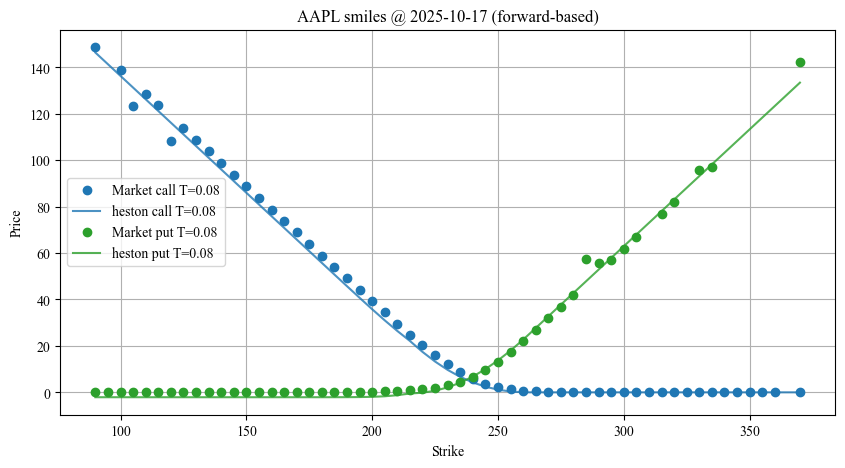

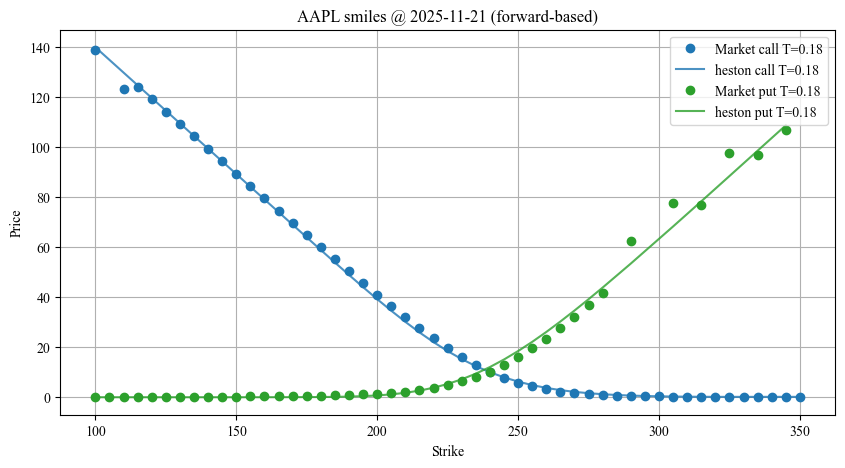

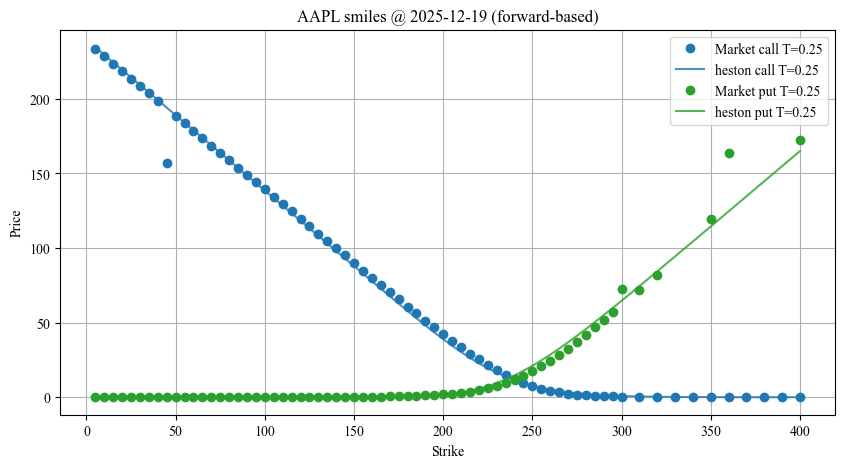

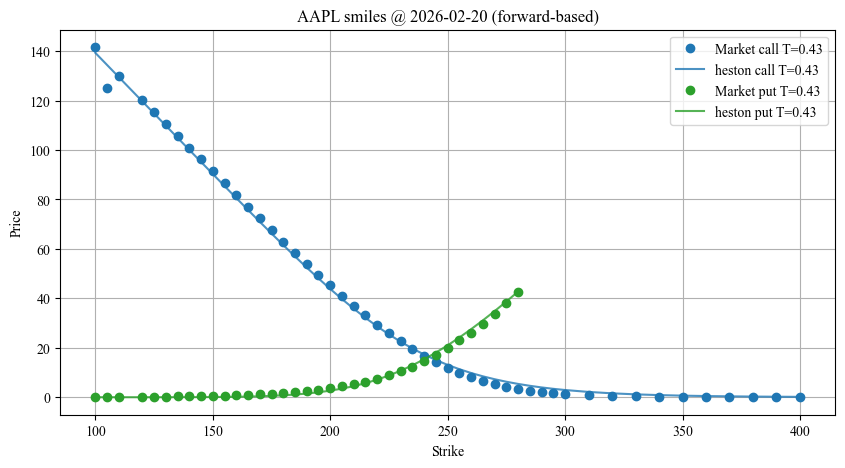

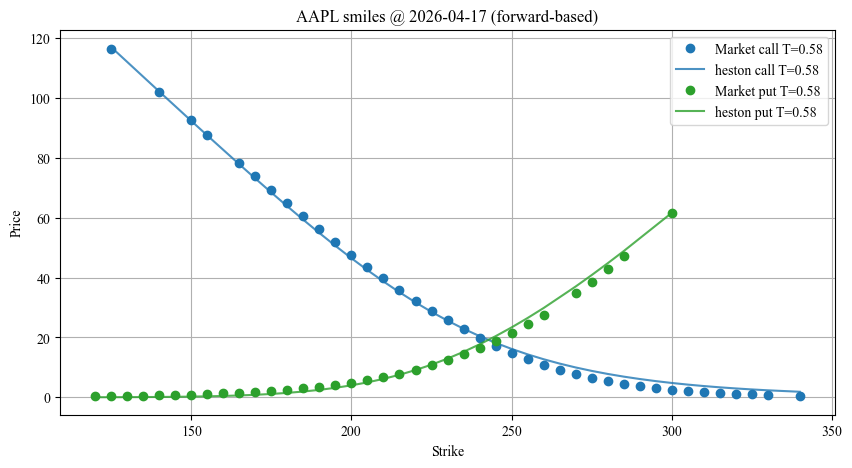

In [16]:
kappa_f, theta_f, sigma_f, v0_f, rho_f = res.x

df_f["exp_utc"] = pd.to_datetime(df_f["expiration"], utc=True)
now_utc = pd.Timestamp.now(tz="UTC")
sel_exps = np.sort(df_f.loc[(df_f["exp_utc"]-now_utc)>pd.Timedelta(days=10), "exp_utc"].unique())[:5]

for exp in sel_exps:
    sl = df_f[df_f["exp_utc"]==exp].copy().sort_values("K")
    if len(sl) < 6:
        continue
    sl["model"] = [
        heston_price(r["S_adj"], r["K"], float(r["T"]), float(r["r_eff"]),
                     kappa_f, theta_f, sigma_f, v0_f, rho_f,
                     option=r["side"], N=4096, L=12)
        for _, r in sl.iterrows()
    ]
    for side, mkr, col in [("call","o","tab:blue"),("put","o","tab:green")]:
        s = sl[sl["side"]==side]
        if len(s) < 3:
            continue
        plt.plot(s["K"], s["mid"], mkr, color=col, label=f"Market {side} T={s['T'].iloc[0]:.2f}")
        plt.plot(s["K"], s["model"], "-", color=col, alpha=0.8, label=f"heston {side} T={s['T'].iloc[0]:.2f}")
    plt.title(f"{TICKER} smiles @ {pd.to_datetime(exp).date()} (forward-based)")
    plt.xlabel("Strike"); plt.ylabel("Price"); plt.grid(True); plt.legend()
    plt.show()


## Step 6: Fit quality
Compute mean and median absolute pricing errors.


In [9]:
df_eval = df_f.copy()
df_eval["model"] = [
    heston_price(r["S_adj"], r["K"], float(r["T"]), float(r["r_eff"]),
                 kappa_f, theta_f, sigma_f, v0_f, rho_f,
                 option=r["side"], N=4096, L=12)
    for _, r in df_eval.iterrows()
]
df_eval["abs_err"] = np.abs(df_eval["model"] - df_eval["mid"])
print("Mean abs error:", df_eval["abs_err"].mean())
print("Median abs error:", df_eval["abs_err"].median())


Mean abs error: 2.2409069650092808
Median abs error: 1.2390708902442178


## Step 7: Synthetic market generator & self-check
We generate a synthetic option surface from known Heston parameters, add a touch of noise, then re-calibrate to see if we recover the ground truth.


In [10]:
rng = np.random.default_rng(42)

# --- Ground truth ("market") parameters ---
S0_true   = 100.0
r_true    = 0.02       # flat risk-free
q_true    = 0.01       # flat dividend (used only to build synthetic forwards)
kappa_t   = 2.5
theta_t   = 0.06
sigma_t   = 0.7
v0_t      = 0.05
rho_t     = -0.6

# Maturities & strikes
Ts_grid   = np.array([0.1, 0.25, 0.5, 1.0, 2.0])     # years
Ks_grid   = np.arange(60, 141, 5).astype(float)      # strikes

# Synthetic "quote date"
asof = pd.Timestamp.utcnow().tz_localize(None)

rows = []
for T in Ts_grid:
    # Forward/discount from (r,q) to emulate market
    DF_T = np.exp(-r_true * T)
    F0T  = S0_true * np.exp((r_true - q_true) * T)
    S_adj = S0_true * np.exp(-q_true * T)           # = DF_T * F0T

    for K in Ks_grid:
        # Model prices (clean)
        c_clean = heston_price(S_adj, K, T, r_true, kappa_t, theta_t, sigma_t, v0_t, rho_t,
                               option="call", N=4096, L=12)
        p_clean = heston_price(S_adj, K, T, r_true, kappa_t, theta_t, sigma_t, v0_t, rho_t,
                               option="put",  N=4096, L=12)

        # Add mild "microstructure" noise (~1–2% of premium, capped)
        noise_c = c_clean * rng.normal(0.0, 0.015)
        noise_p = p_clean * rng.normal(0.0, 0.015)
        c_mid = max(c_clean + noise_c, 0.01)
        p_mid = max(p_clean + noise_p, 0.01)

        # Fake bid/ask around mid so we can build weights
        spr_c = max(0.05, 0.02 * c_mid)
        spr_p = max(0.05, 0.02 * p_mid)

        exp = asof + pd.Timedelta(days=int(round(T * 365.25)))
        rows.append(dict(expiration=exp, strike=K, type="call", mid=c_mid, bid=c_mid-0.5*spr_c, ask=c_mid+0.5*spr_c))
        rows.append(dict(expiration=exp, strike=K, type="put",  mid=p_mid, bid=p_mid-0.5*spr_p, ask=p_mid+0.5*spr_p))

df_syn = pd.DataFrame(rows)
df_syn["underlying"] = S0_true
df_syn["K"] = df_syn["strike"].astype(float)
df_syn["side"] = df_syn["type"]
df_syn["T"] = (df_syn["expiration"] - asof).dt.days / 365.25

# Weights: inverse spread
spr = (df_syn["ask"] - df_syn["bid"]).clip(lower=0.05)
df_syn["w"] = 1.0 / spr

df_syn = df_syn[(df_syn["T"] > 2/365) & (df_syn["mid"] > 0)].copy()
df_syn.head()


,expiration,strike,type,mid,bid,ask,underlying,K,side,T,w
0,2025-10-24 00:07:44.478696,60.0,call,37.332609,36.959283,37.705935,100.0,60.0,call,0.1013,1.339312
1,2025-10-24 00:07:44.478696,60.0,put,0.010000,-0.015000,0.035000,100.0,60.0,put,0.1013,20.000000
2,2025-10-24 00:07:44.478696,65.0,call,32.535279,32.209926,32.860632,100.0,65.0,call,0.1013,1.536793
3,2025-10-24 00:07:44.478696,65.0,put,0.010000,-0.015000,0.035000,100.0,65.0,put,0.1013,20.000000
4,2025-10-24 00:07:44.478696,70.0,call,26.389772,26.125875,26.653670,100.0,70.0,call,0.1013,1.894673


### Infer forwards/discounts from synthetic quotes (parity OLS)
This mirrors the earlier regression but on the synthetic market.


In [11]:
pairs_syn = (df_syn
             .pivot_table(index=["expiration","T","K"], columns="side", values="mid", aggfunc="mean")
             .reset_index())
pairs_syn = pairs_syn.dropna(subset=["call","put"]).copy()
pairs_syn["y"] = pairs_syn["call"] - pairs_syn["put"]

per_exp_syn = []
for (exp,), grp in pairs_syn.groupby(["expiration"]):
    K = grp["K"].values
    y = grp["y"].values
    if len(K) < 3:
        continue
    X = np.vstack([np.ones_like(K), K]).T
    beta, *_ = np.linalg.lstsq(X, y, rcond=None)
    a, b = beta
    DF = max(1e-9, -b)
    F  = a / DF
    T  = float(np.nanmean(grp["T"]))
    per_exp_syn.append({"expiration": pd.to_datetime(exp), "T": T, "DF": DF, "F0T": F})
forw_syn = pd.DataFrame(per_exp_syn)
forw_syn["r_eff"] = np.where(forw_syn["T"]>0, -np.log(forw_syn["DF"]) / forw_syn["T"], 0.0)
forw_syn.sort_values("T").head()


,expiration,T,DF,F0T,r_eff
0,2025-10-24 00:07:44.478696,0.101300,0.947272,98.911255,0.534732
1,2025-12-17 00:07:44.478696,0.249144,0.985353,99.999357,0.059223
2,2026-03-19 00:07:44.478696,0.501027,0.987414,100.506590,0.025280
3,2026-09-17 00:07:44.478696,0.999316,0.971769,101.086041,0.028657
4,2027-09-17 00:07:44.478696,1.998631,0.960633,102.069363,0.020095


### Build forward-adjusted dataset and calibrate
We’ll reuse the same forward-based objective (`heston_mse_forward`).


In [12]:
# join forwards
df_f_syn = (df_syn
            .merge(forw_syn[["expiration","DF","F0T","r_eff","T"]], on=["expiration","T"], how="inner")
            .copy())
df_f_syn["S_adj"] = df_f_syn["DF"] * df_f_syn["F0T"]

# (Optionally) filter out near-expiry or dust quotes
df_f_syn = df_f_syn[(df_f_syn["T"] > 7/365) & (df_f_syn["mid"] > 0.02)].copy()

# Calibrate
from scipy.optimize import minimize

x0 = np.array([2.0, 0.05, 0.6, 0.05, -0.5])   # decent initials
bounds = [(1e-3,15.0),(1e-4,0.8),(1e-3,4.0),(1e-4,1.0),(-0.999,0.999)]

iter_log = {"count":0, "last":None}
def cb(xk):
    iter_log["count"] += 1
    f = heston_mse_forward(xk, df_f_syn, vega_weight=True, feller_penalty=True)
    rel = np.nan if iter_log["last"] is None else (iter_log["last"]-f)/max(abs(iter_log["last"]),1e-12)
    iter_log["last"] = f
    if iter_log["count"] % 5 == 0:  # print every 5 iters to keep output tidy
        print(f"Iter {iter_log['count']:3d}  obj={f:.6e}  Δrel={rel:.3e}")

res_syn = minimize(lambda x: heston_mse_forward(x, df_f_syn, vega_weight=True, feller_penalty=True),
                   x0, method="L-BFGS-B", bounds=bounds, options=dict(maxiter=400, disp=False),
                   callback=cb)

print("Success:", res_syn.success, res_syn.message)
print("Fitted params:", res_syn.x)
print("Objective value:", res_syn.fun)

print("\nTrue params:   ", [kappa_t, theta_t, sigma_t, v0_t, rho_t])
print("Recovered params:", list(np.round(res_syn.x, 4)))


C:\Users\datog\AppData\Local\Temp\ipykernel_6244\4200687027.py:25: DeprecationWarning: scipy.optimize: The `disp` and `iprint` options of the L-BFGS-B solver are deprecated and will be removed in SciPy 1.18.0.
  res_syn = minimize(lambda x: heston_mse_forward(x, df_f_syn, vega_weight=True, feller_penalty=True),


Iter   5  obj=1.102839e-01  Δrel=2.637e-02
Iter  10  obj=8.968491e-02  Δrel=4.326e-03
Iter  15  obj=5.523430e-02  Δrel=5.001e-03
Iter  20  obj=5.507881e-02  Δrel=8.042e-04
Iter  25  obj=5.349604e-02  Δrel=4.033e-03
Iter  30  obj=5.345542e-02  Δrel=2.170e-05
Iter  35  obj=5.317180e-02  Δrel=3.939e-03
Iter  40  obj=5.236781e-02  Δrel=2.363e-03
Iter  45  obj=5.137450e-02  Δrel=3.347e-03
Iter  50  obj=5.115012e-02  Δrel=4.046e-04
Iter  55  obj=5.114216e-02  Δrel=1.023e-05
Iter  60  obj=5.113728e-02  Δrel=2.076e-07
Success: True CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
Fitted params: [ 3.59338543e+00  9.55925185e-02  7.56958988e-01  1.00000000e-04
 -7.27276093e-01]
Objective value: 0.05113727596093492

True params:    [2.5, 0.06, 0.7, 0.05, -0.6]
Recovered params: [np.float64(3.5934), np.float64(0.0956), np.float64(0.757), np.float64(0.0001), np.float64(-0.7273)]


### Validate fit on synthetic quotes
Compute errors and plot a couple of synthetic smiles with model overlay.


Synthetic mean abs error : 0.2667498837204186
Synthetic median abs err: 0.13438503382537537


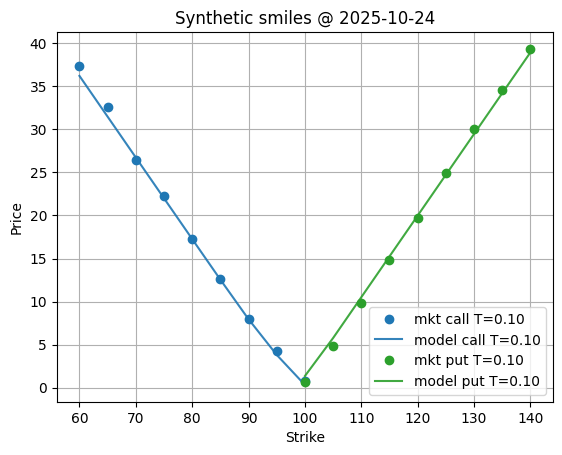

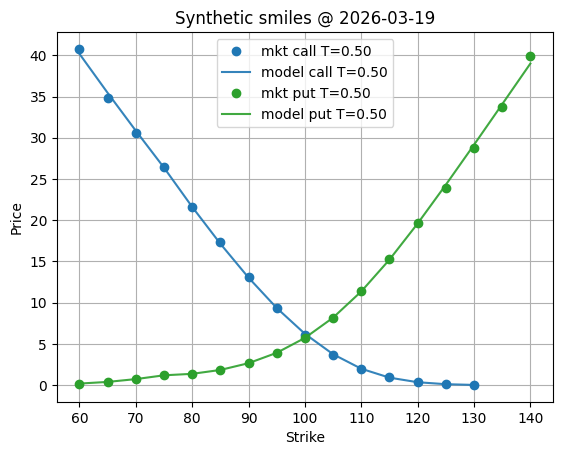

In [ ]:
# Evaluate errors
df_eval_syn = df_f_syn.copy()
kappa_f, theta_f, sigma_f, v0_f, rho_f = res_syn.x

df_eval_syn["model"] = [
    heston_price(r["S_adj"], r["K"], float(r["T"]), float(r["r_eff"]),
                 kappa_f, theta_f, sigma_f, v0_f, rho_f,
                 option=r["side"], N=4096, L=12)
    for _, r in df_eval_syn.iterrows()
]
df_eval_syn["abs_err"] = np.abs(df_eval_syn["model"] - df_eval_syn["mid"])
print("Synthetic mean abs error :", df_eval_syn["abs_err"].mean())
print("Synthetic median abs err:", df_eval_syn["abs_err"].median())

# Plot 2 example expiries
exps = np.sort(df_eval_syn["expiration"].unique())[:2]
for exp in exps:
    sl = df_eval_syn[df_eval_syn["expiration"]==exp].copy().sort_values("K")
    for side, color in [("call","tab:blue"), ("put","tab:green")]:
        s = sl[sl["side"]==side]
        if len(s) < 3: continue
        plt.plot(s["K"], s["mid"], "o", color=color, label=f"Market {side} T={s['T'].iloc[0]:.2f}")
        plt.plot(s["K"], s["model"], "-", color=color, alpha=0.9, label=f"model {side} T={s['T'].iloc[0]:.2f}")
    plt.title(f"Synthetic smiles @ {pd.to_datetime(exp).date()}")
    plt.xlabel("Strike"); plt.ylabel("Price"); plt.grid(True); plt.legend()
    plt.show()


### Notes
- Because the synthetic market is generated **from the same model**, the recovered parameters should be very close to truth (up to noise and optimizer tolerance).
- If you increase `noise` or reduce quotes, expect wider gaps.
- This harness is useful for **regression tests**: if you change the pricer, confirm you still recover the same parameters on synthetic data.
